# Тестовое задание "Задача по анализу поиска в Яндекс Картинках"

## Задачи
1.	Укажите даты диапазона предоставленного вам для анализа?
2.	Рассчитайте кол-во запросов с текстом "ютуб" в каждой платформе (desktop, touch)
3.	Выведите топ10 самых частотных запросов в каждой платформе (desktop, touch). Какие отличия вы видите?
4.	Посмотрите, чем отличается трафик запросов в течение дня. Как можно объяснить отличие?
5.	Выделите тематики запросов, контрастные для мобильных и компьютеров - темы, доля которых отличаются на разных платформах

In [1]:
import pandas as pd
import pandasql as ps

df = pd.read_csv('./data/data.tsv', sep='\t', names=["search_line", "time", "platform"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1203824 entries, 0 to 1203823
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   search_line  1203824 non-null  object
 1   time         1203824 non-null  int64 
 2   platform     1203824 non-null  object
dtypes: int64(1), object(2)
memory usage: 27.6+ MB


In [2]:
df.head(10)

,search_line,time,platform
0,порно фото,1631786697,touch
1,малевич картины,1631806465,desktop
2,Секс,1631781583,touch
3,с днём рождения лена,1631771563,touch
4,зверополис порно,1631787599,touch
5,алабай собака фото,1631786645,touch
6,бактериофаг,1631816202,desktop
7,полина гагарина,1631804005,touch
8,кадр из фильма,1631770837,desktop
9,porno,1631780741,touch


## Задача 1

Укажите даты диапазона предоставленного вам для анализа?

Поскольку не указано time zone информация, будем считать даты по **UTC**.

In [3]:
df["date"] = pd.to_datetime(ps.sqldf("SELECT datetime(time, 'unixepoch', '+0 hours') as date FROM df")["date"])
df.head(10)

,search_line,time,platform,date
0,порно фото,1631786697,touch,2021-09-16 10:04:57
1,малевич картины,1631806465,desktop,2021-09-16 15:34:25
2,Секс,1631781583,touch,2021-09-16 08:39:43
3,с днём рождения лена,1631771563,touch,2021-09-16 05:52:43
4,зверополис порно,1631787599,touch,2021-09-16 10:19:59
5,алабай собака фото,1631786645,touch,2021-09-16 10:04:05
6,бактериофаг,1631816202,desktop,2021-09-16 18:16:42
7,полина гагарина,1631804005,touch,2021-09-16 14:53:25
8,кадр из фильма,1631770837,desktop,2021-09-16 05:40:37
9,porno,1631780741,touch,2021-09-16 08:25:41


In [4]:
print(ps.sqldf("""
    SELECT 'Диапазон дат: ' || STRFTIME('%d.%m.%Y', DATE(MIN(date))) || ' - ' || STRFTIME('%d.%m.%Y', DATE(MAX(date))) as result
    FROM df
    ORDER BY time
    DESC
    LIMIT 1
""")['result'][0])

Диапазон дат: 31.08.2021 - 21.09.2021


## Задача 2

Рассчитайте кол-во запросов с текстом "ютуб" в каждой платформе (desktop, touch)


In [5]:
youtube_count_df = ps.sqldf("""
    SELECT platform, COUNT(time) as count
    FROM df
    WHERE search_line='ютуб'
    GROUP BY platform
""")
youtube_count_df

,platform,count
0,desktop,714
1,touch,476


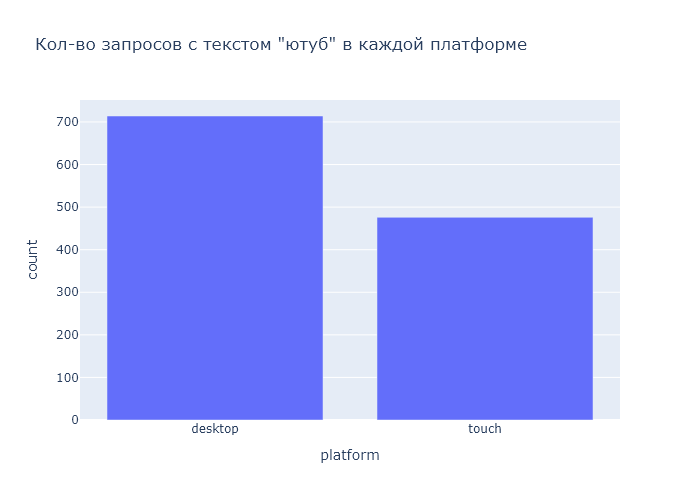

In [6]:
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly"
fig = px.bar(youtube_count_df, x='platform', y='count', title='Кол-во запросов с текстом "ютуб" в каждой платформе')
fig.show(renderer="png")

## Задача 3

Выведите топ10 самых частотных запросов в каждой платформе (desktop, touch). Какие отличия вы видите?

In [7]:
search_line_cnt_df = ps.sqldf("""
    SELECT search_line, platform, count
    FROM (
        SELECT
            search_line,
            platform,
            COUNT(time) as count,
            ROW_NUMBER() OVER (PARTITION BY platform ORDER BY COUNT(time) DESC) AS rn
        FROM df
        GROUP BY search_line, platform
    )
    WHERE rn <= 10
""")
search_line_cnt_df.head(10)

,search_line,platform,count
0,календарь 2021,desktop,2804
1,таблица менделеева,desktop,2631
2,картинки,desktop,1647
3,порно,desktop,1342
4,английский алфавит,desktop,1293
5,обои на рабочий стол,desktop,1143
6,Одноклассники (социальная сеть),desktop,1116
7,секс,desktop,895
8,таблица квадратов,desktop,877
9,алфавит,desktop,874


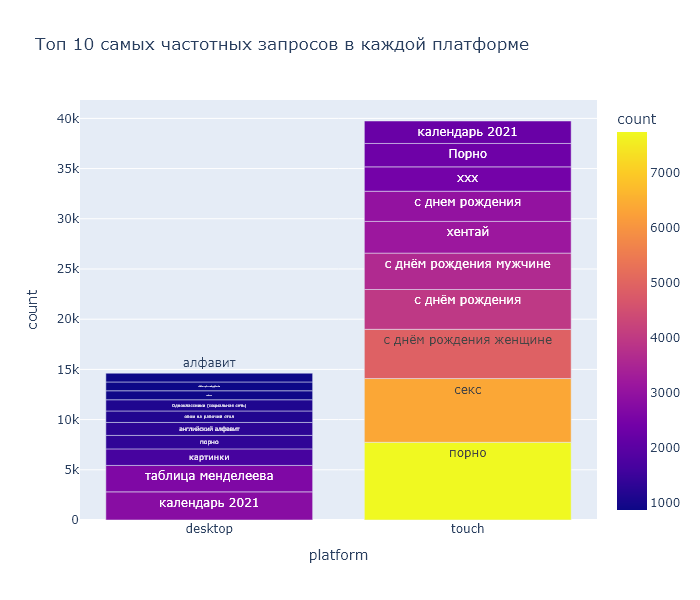

In [8]:
fig = px.bar(search_line_cnt_df, x='platform', y='count', title='Топ 10 самых частотных запросов в каждой платформе', text='search_line', color="count", height=600)
fig.show(renderer="png")

Исходя из диаграммы можно увидеть следующее:
- На мобильных устройства чаще всего ищут контент 18+, а также поздравления с днём рождения и календарь
- На компьютерах чаще всего ищут календарь, таблицу менделеева и картинки

Заметны существенные различия между платформами: на мобильных устройствах очень распространён поиск 18+ контента и поздравлений с днём рождения в отличие от ПК. На пк 18+ контент достаточно популярен, но не настолько.


## Задача 4

Посмотрите, чем отличается трафик запросов в течении дня. Как можно объяснить отличие?

In [9]:
count_by_time = ps.sqldf("""
    SELECT strftime('%H:%M:%S', datetime(time - time % (30 * 60), 'unixepoch', '+0 hours')) as msc_time, COUNT(time) as count
    FROM df
    GROUP BY msc_time
""")
count_by_time.head(10)

,msc_time,count
0,00:00:00,4873
1,00:30:00,5145
2,01:00:00,5848
3,01:30:00,6792
4,02:00:00,7990
5,02:30:00,9532
6,03:00:00,12476
7,03:30:00,15440
8,04:00:00,18889
9,04:30:00,21890


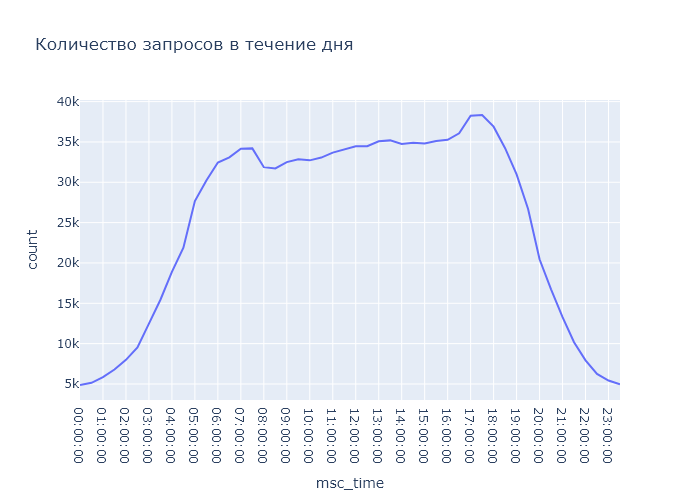

In [10]:
fig = px.line(count_by_time, x='msc_time', y='count', title='Количество запросов в течение дня')
fig.show(renderer="png")

По графику видно, что количество запросов зависит от времени суток.

Ночью запросов минимум. Это можно объяснить тем, что люди в это время спят.

Есть 2 пика запросов: в 7-8 часов утра и в 5-6 часов вечера. В это утреннее время люди собираются или едут на работу. А в данное вечернее время обычно заканчивается рабочий день. Поэтому люди более активные в эти времена.

Также можно заметить, что в течение рабочего дня количество запросов понемногу растёт. На это могут сказываться следующие причины:
- снижение концентрации работников на рабочих задачах, в следствии чего они всё больше проводят времени в интернете;
- конец занятий у школьников/студентов и последующее выполнение домашних заданий (обычно ближе к вечеру) с помощью поисковика.


## Задача 5

Выделите тематики запросов, контрастные для мобильных и компьютеров - темы, доля которых отличаются на разных платформах

In [11]:
grouped_search_line = df[:]
grouped_search_line['search_line'] = df['search_line'].str.lower().str.strip()
grouped_search_line = ps.sqldf("""
    SELECT search_line, platform, COUNT(*) as count
    FROM grouped_search_line
    GROUP BY search_line, platform
""")
grouped_search_line.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46593 entries, 0 to 46592
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   search_line  46593 non-null  object
 1   platform     46593 non-null  object
 2   count        46593 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [12]:
topics = [
    ['школа', ['таблиц', 'формул', 'падежи', 'дискриминант', 'теорем', 'синтаксический разбор предложения']],
    ['открытки', ['с днём рождения женщине', 'с днем рождения', 'с днём рождения мужчине', 'с днём рождения']],
    ['айфон', ['айфон', 'iphone']],
    ['18+', ['секс', 'хентай', 'сиськи', 'porn', 'порн', 'голые', 'голый', 'пизда', 'sex', 'boob']],
    ['люди', ['девушка', 'девушки', 'белла торн', 'тимур бекмансуров', 'жан-поль бельмондо', 'моргенштерн', 'женщины', 'инстасамка', 'путин', 'женщина']],
    ['информация', ['календарь', 'алфавит', 'карта', 'текст', 'флаг', 'расписание', 'герб', 'цифры', 'схема', '1 сентября']],
    ['сайты', ['одноклассники (социальная сеть)', 'youtube', 'ютуб', 'вк', 'minecraft', 'переводчик', 'яндекс', 'портал государственных услуг российской федерации', 'whatsapp', 'майнкрафт']],
    ['обои', ['обои ', 'осень', 'обои', 'космос']],
    ['аниме', ['аниме', 'наруто', 'токийские мстители', '13 карт']],
    ['без категории', ['картинки', 'фото', 'раскраски', 'рисунки', 'спасибо за внимание', 'фон', 'раскраска', 'мемы']],
]

grouped_search_line['topic_name'] = 'другое'
for topic_name, values in topics:
    for val in values:
        grouped_search_line.loc[grouped_search_line['search_line'].str.contains(val), 'topic_name'] = topic_name

grouped_topics = ps.sqldf("""
    SELECT
        topic_name,
        platform,
        SUM(count) * 1.0 / SUM(SUM(count)) OVER (PARTITION BY platform) AS distribution
    FROM grouped_search_line
    GROUP BY topic_name, platform
""")

grouped_topics.head(10)

C:\Users\danil\AppData\Local\Temp\ipykernel_22108\785505367.py:17: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



,topic_name,platform,distribution
0,18+,desktop,0.023510
1,айфон,desktop,0.001667
2,аниме,desktop,0.014469
3,без категории,desktop,0.089227
4,другое,desktop,0.693395
5,информация,desktop,0.075937
6,люди,desktop,0.018218
7,обои,desktop,0.017859
8,открытки,desktop,0.012683
9,сайты,desktop,0.018629


In [13]:
difference_df = ps.sqldf("""
    SELECT
        desk_df.topic_name as topic_name,
        desk_df.distribution - touch_df.distribution as difference
    FROM (SELECT * FROM grouped_topics WHERE platform='desktop') as desk_df
    JOIN (SELECT * FROM grouped_topics WHERE platform='touch') as touch_df
    ON desk_df.topic_name=touch_df.topic_name AND desk_df.topic_name!='другое'
    ORDER BY difference
""")
difference_df.head(10)

,topic_name,difference
0,открытки,-0.052051
1,18+,-0.051648
2,люди,-0.002682
3,айфон,-0.000418
4,аниме,0.001613
5,без категории,0.007269
6,сайты,0.007650
7,обои,0.009344
8,школа,0.019166
9,информация,0.022558


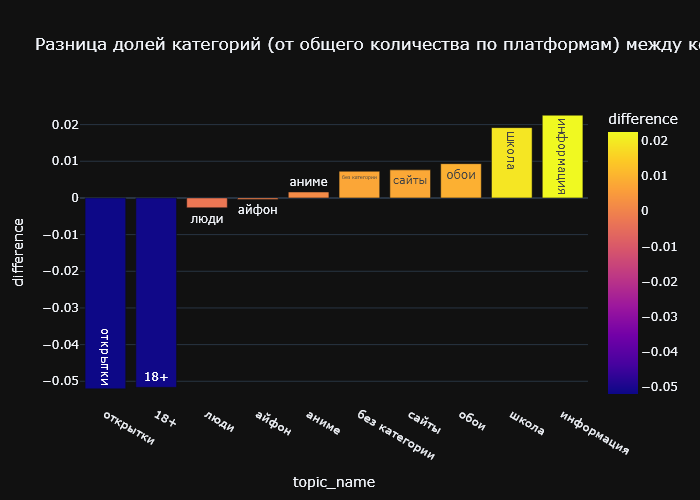

In [14]:
fig = px.bar(difference_df.sort_values(by=['difference']), x='topic_name', y='difference', title='Разница долей категорий (от общего количества по платформам) между компьютерами и мобильными', text='topic_name', color="difference")
fig.show(renderer="png")

По графику видно, что контрастными тематиками для мобильных и компьютеров являются "открытки", "18+ контент", "школа" и "информация".

То есть на мобильных устройствах люди намного чаще ищут 18+ контент и различные открытки. На компьютерах чаще ищут информацию по типу календаря или карт, а также школьную информацию по типу всяких формул и таблиц.
